# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

from category_encoders import TargetEncoder

from data_preparation import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
test_prepared = pd.read_csv('./data/test_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()
train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])
test_prepared['date_mensuelle'] = pd.to_datetime(test_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)
test_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
test_prepared['CODE_GENDER'] = test_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
#dataprep = DataPreparation(train, test, 0.3)

In [4]:
df_met = pd.read_csv('./data/variables_sens_metier_discretisees.csv')
df_met['date_mensuelle'] = pd.to_datetime(df_met['date_mensuelle'])
#train_prepared = df_met.copy()
train_prepared = train_prepared.merge(df_met[['AMT_CREDIT_SUM_DEBT_disc','AMT_CREDIT_SUM_disc','NAME_EDUCATION_TYPE_discret','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [10]:
X = train_prepared.drop(columns=['date_mensuelle'])
y = train_prepared['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Selection de var

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna

variables = X_train.columns

var_supp = []

prev_auc = 0


while len(variables)>6:
    
    study = optuna.create_study(direction='maximize')
    
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-3, 5)
        logistic_model = LogisticRegression(C=C)
        logistic_model.fit(X_train[variables], y_train)
        y_prob = logistic_model.predict_proba(X_test[variables])[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        return auc
    
    study.optimize(objective, n_trials=10)
    
    logistic_model = LogisticRegression(C=study.best_params['C'])
    logistic_model.fit(X_train[variables], y_train)
    
    y_prob = logistic_model.predict_proba(X_test[variables])[:, 1]
    
    current_auc = roc_auc_score(y_test, y_prob)
    
    if current_auc > 0.74:
        var_finales = variables.copy()
        f1_final = current_auc
        param_final = study.best_params['C']
        
    min_coef_idx = np.argmin(np.abs(logistic_model.coef_))
    
    variables = list(variables)
    variables.pop(min_coef_idx)

    var_supp.append(min_coef_idx)
    
    prev_auc = current_auc

# Afficher les résultats
print("Meilleur alpha trouvé :", param_final)
print("Meilleue AUC trouvé :", f1_final)
print("Variables sélectionnées :", var_finales)


# Logit statsmodels

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23601629967597051
            Iterations: 85
            Function evaluations: 86
            Gradient evaluations: 85


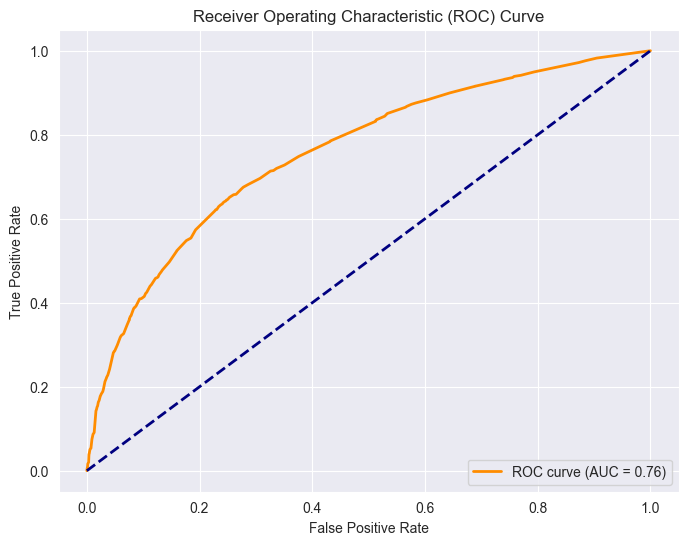

0.5160442553364588

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

features = ['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'EXT_SOURCE_2_disc_int',  'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int','NAME_INCOME_TYPE_discret']

replacement_dict = {1: 'un', 0: 'zero', 2: 'deux', 3: 'trois'}

df_train = X_train.copy()
df_validation = X_test.copy()

for var in features:
   df_train[var] = df_train[var].replace(replacement_dict)
   df_validation[var] = df_validation[var].replace(replacement_dict)


df_train["TARGET"] = df_train["TARGET"].astype("int")


reference_categories = {var: df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(alpha=0.002716051611444723)

# Prédiction
pred = logit_model.predict(df_validation)
fpr, tpr, thresholds = roc_curve(df_validation["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

In [13]:
logit_model.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.755000,0.021385,-175.591516,0.000000e+00,-3.796914,-3.713087
"C(AMT_CREDIT_SUM_DEBT_disc, Treatment(reference=""zero""))[T.deux]",0.967544,0.021204,45.631025,0.000000e+00,0.925986,1.009102
"C(AMT_CREDIT_SUM_DEBT_disc, Treatment(reference=""zero""))[T.un]",1.631022,0.020778,78.499340,0.000000e+00,1.590299,1.671745
"C(AMT_CREDIT_SUM_disc, Treatment(reference=""un""))[T.zero]",0.872518,0.018644,46.798991,0.000000e+00,0.835977,0.909060
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.09;0.45]]",0.708160,0.016871,41.975281,0.000000e+00,0.675093,0.741226
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.0;0.09]]",1.430213,0.030372,47.089968,0.000000e+00,1.370685,1.489741
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.07;0.41]]",0.124530,0.020408,6.102060,1.047099e-09,0.084532,0.164529
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.41;0.96]]",-0.577897,0.021655,-26.686009,6.841443e-157,-0.620341,-0.535453
"C(EXT_SOURCE_3_disc_int, Treatment(reference=""[0.31;0.9]""))[T.[0.0;0.31]]",0.736935,0.018373,40.109258,0.000000e+00,0.700924,0.772945
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.low_income]",1.487256,0.511347,2.908505,3.631610e-03,0.485034,2.489478



# Xgboost

In [16]:
for col in train_prepared.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared[col], prefix=col, drop_first=True)
    train_prepared = train_prepared.drop(col, axis=1)
    train_prepared = train_prepared.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in train_prepared.select_dtypes(include=bool).columns:
    train_prepared[col] = train_prepared[col].astype(int)

In [25]:
X = train_prepared[['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'EXT_SOURCE_2_disc_int_[0.0;0.09]', 'EXT_SOURCE_2_disc_int_[0.45;0.85]',
       'EXT_SOURCE_1_disc_int_[0.0;0.07]', 'EXT_SOURCE_1_disc_int_[0.41;0.96]', 'EXT_SOURCE_3_disc_int_[0.31;0.9]','NAME_INCOME_TYPE_discret_low_income', 'NAME_INCOME_TYPE_discret_other']]
y = train_prepared['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [26]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [27]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assume X_train, X_test, y_train, y_test are defined

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2, y_train)
    y_pred = model.predict(X_test2)
    report = classification_report(y_test,y_pred,output_dict=True)
    f_one = report['1']['f1-score']
    return f_one

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-24 10:36:29,109] A new study created in memory with name: no-name-f1274b40-1500-4bf8-a1e3-549b94841e93
[I 2024-02-24 10:36:31,813] Trial 0 finished with value: 0.16486931091208187 and parameters: {'max_depth': 20, 'eta': 0.05706441602724459, 'gamma': 2.1004334417859393e-08, 'colsample_bytree': 0.7064290216605131, 'subsample': 0.8876126697721622, 'n_estimators': 145, 'alpha': 0.08905339812174386}. Best is trial 0 with value: 0.16486931091208187.
[I 2024-02-24 10:36:33,265] Trial 1 finished with value: 0.16486931091208187 and parameters: {'max_depth': 13, 'eta': 0.10991224873984365, 'gamma': 4.376367813836852e-06, 'colsample_bytree': 0.5728341708963864, 'subsample': 0.627291749318534, 'n_estimators': 130, 'alpha': 0.11531017802693107}. Best is trial 0 with value: 0.16486931091208187.
[I 2024-02-24 10:36:34,253] Trial 2 finished with value: 0.0550122249388753 and parameters: {'max_depth': 19, 'eta': 0.1667215190713718, 'gamma': 0.011416616164891952, 'colsample_bytree': 0.306057

Best parameters: {'max_depth': 9, 'eta': 0.05845438977724135, 'gamma': 0.016038102295840902, 'colsample_bytree': 0.9222424362522816, 'subsample': 0.6811311772695439, 'n_estimators': 126, 'alpha': 0.43095333686028275}
Best positive f1 score: 0.1649296032181386


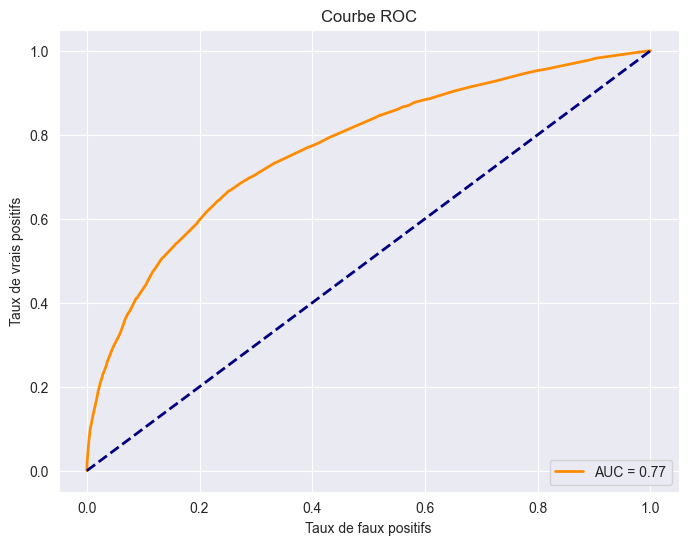

In [29]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



params = {'max_depth': 7, 'eta': 0.3619081800824767, 'gamma': 6.977954148681437e-06, 'colsample_bytree': 0.8736582384510414, 'subsample': 0.6583654387290991, 'n_estimators': 143, 'alpha': 0.19270106587750738}

params = study.best_params

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train2, y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test2)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

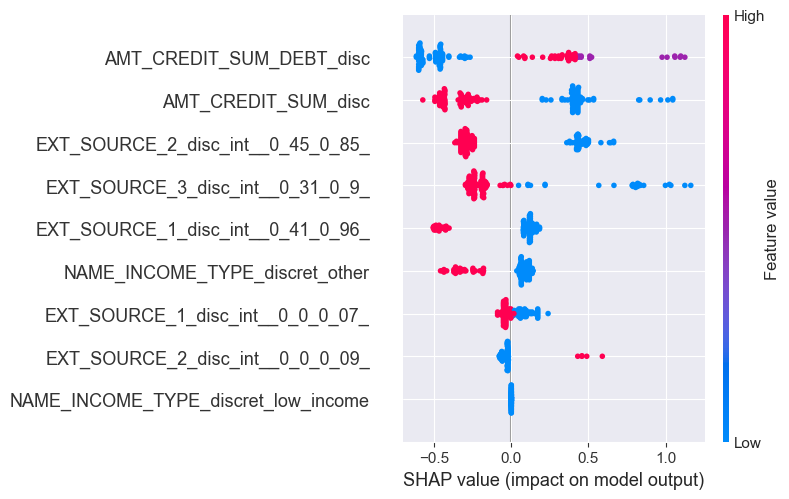

In [31]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train2.iloc[:150, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train2.iloc[:150, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train2.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2.iloc[[0]])

In [33]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 15
top_variables = X_train2.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc',
       'EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_',
       'EXT_SOURCE_1_disc_int__0_41_0_96_', 'NAME_INCOME_TYPE_discret_other',
       'EXT_SOURCE_1_disc_int__0_0_0_07_', 'EXT_SOURCE_2_disc_int__0_0_0_09_',
       'NAME_INCOME_TYPE_discret_low_income'],
      dtype='object')